## Importing the needed libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import datetime

import warnings
warnings.filterwarnings('ignore')

## Importing the *orders* data set

In [2]:
orders_path = '../orders_after_cleaning.csv'

Dob - date of birth;

PoR - customer place of residence;

EDT - expected delivery time;

ADT - actual delivery time; 

RoR - reason of return

In [3]:
df_orders = pd.read_csv(orders_path,
                        #parse_dates=['DoB', 'Order date'], //Way too slow
                        dtype=
                        {'Customer number': np.int64,
                         'Gender': object,
                         'PoR': object,
                         'Order number': np.int64,
                         'Product number': object,
                         'Sub category': object,
                         'Category': object,
                         'Count': np.int16,
                         'Price': np.float64,
                         'EDT': np.int16,
                         'ADT': np.int16,
                         'RoR': object,
                         'Rating': np.int8,
                         'Returned': np.float64,
                         'Price per Product': np.float64,
                         'Man': np.float64,
                         'Woman': np.float64,
                         'Age': np.int64,
                         'Order month': np.int64,
                         'Order year': np.int64,
                         'DeltaT': np.int64})

# Forecasting demand
Predict the demand of garden furniture for 2019.

In [4]:
df_furniture = df_orders.copy().loc[df_orders['Category']=='Garden furniture']

In [5]:
df_furniture.head(10)

,Unnamed: 0,Customer number,DoB,Gender,PoR,Order number,Order date,Product number,Sub category,Category,...,RoR,Rating,Returned,Price per Product,Man,Woman,Age,Order month,Order year,DeltaT
0,0,1063418,1944-01-15,Woman,Bloemendaal,1251137,2014-12-20,5146308036084,Garden chairs,Garden furniture,...,NaN,-1,0.0,1090.82,0.0,1.0,74,12,2014,718
5,5,1016474,1937-01-16,Man,Hollands Kroon,294578,2014-08-19,8188604007365,Garden chairs,Garden furniture,...,NaN,-1,0.0,940.43,1.0,0.0,81,8,2014,595
8,8,1018918,1974-01-07,Woman,Coevorden,1202222,2014-09-19,3193523049599,Garden sets,Garden furniture,...,No reason given,4,1.0,1079.03,0.0,1.0,44,9,2014,626
13,13,1018918,1974-01-07,Woman,Coevorden,1202222,2014-09-19,3188775004229,Garden chairs,Garden furniture,...,NaN,4,0.0,340.07,0.0,1.0,44,9,2014,626
19,19,1018918,1974-01-07,Woman,Coevorden,1202222,2014-09-19,4169424015147,Garden benches,Garden furniture,...,NaN,4,0.0,1189.15,0.0,1.0,44,9,2014,626
26,26,1032738,1980-01-06,Man,Waterland,997869,2013-07-20,8177666043794,Garden chairs,Garden furniture,...,NaN,-1,0.0,906.65,1.0,0.0,38,7,2013,200
27,27,1029598,1970-01-08,Man,Oss,1606587,2016-07-12,4146448030684,Garden chairs,Garden furniture,...,NaN,-1,0.0,248.06,1.0,0.0,48,7,2016,1288
38,38,1018702,1990-01-03,Man,Terschelling,1433754,2015-12-31,5100706141917,Sun beds,Garden furniture,...,NaN,-1,0.0,66.82,1.0,0.0,28,12,2015,1094
43,43,1060208,1934-01-17,Man,Korendijk,255450,2014-02-06,1130770100774,Sun beds,Garden furniture,...,NaN,-1,0.0,72.87,1.0,0.0,84,2,2014,401
53,53,1068164,1965-01-09,Man,Alphen aan den Rijn,417413,2015-04-20,2142622044388,Garden sets,Garden furniture,...,NaN,-1,0.0,944.79,1.0,0.0,53,4,2015,839


## Sort all the orders by order date. Group by the date and sum the quantity.

In [6]:
df_furniture['Order date'] = pd.to_datetime(df_furniture["Order date"], format="%Y-%m-%d")
df_furniture = df_furniture.sort_values('Order date')
df_furniture = df_furniture.groupby('Order date')['Count'].sum().reset_index()
df_furniture = df_furniture.set_index('Order date')
df_furniture.head(10)

,Count
Order date,
2013-01-01,1844
2013-01-02,1350
2013-01-03,1878
2013-01-04,980
2013-01-05,966
2013-01-06,324
2013-01-07,1744
2013-01-08,1632
2013-01-09,465


## Apply ARIMA model to predict sales
The used prediction model is ARIMA. This is because it is a model for forecasting and predicting timeseries.  
This is perfect for our usecase.

In [7]:
from statsmodels.tsa.arima_model import ARIMA

In [8]:
model = ARIMA(df_furniture['Count'], order=(5,0,0), freq="D")
results = model.fit(disp=0)

In [9]:
forecast = results.predict(start = '01/01/2013', end = '01/01/2019')

Generate a graph with the actual and the predicted data

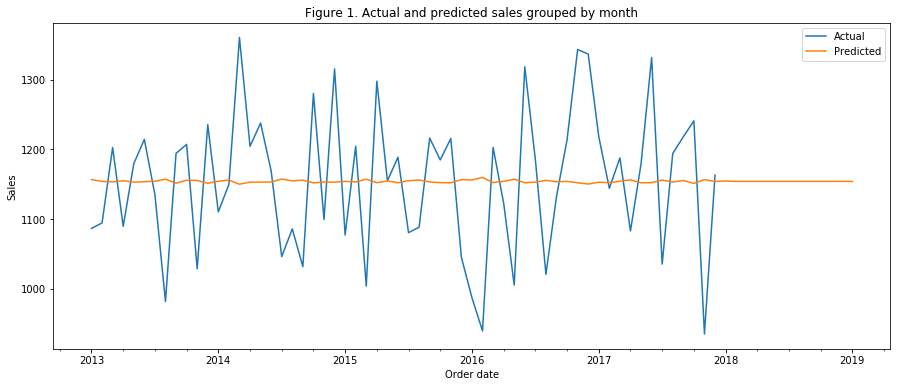

In [10]:
resampled = df_furniture['Count'].resample('MS').mean()
resampled.plot(figsize=(15, 6), label="Actual")
resampled_forecast = forecast.resample('MS').mean()
resampled_forecast.plot(figsize=(15, 6), label="Predicted")
plt.ylabel('Sales')
plt.title('Figure 1. Actual and predicted sales grouped by month')
plt.legend()
plt.show()

Calculate the mean squared error

In [11]:
from sklearn.metrics import mean_squared_error
test_score = mean_squared_error(df_furniture['Count'][1:], forecast[1:len(df_furniture['Count'])])
print('Test MSE: %.3f' % test_score)

Test MSE: 291042.419


Plot residual errors

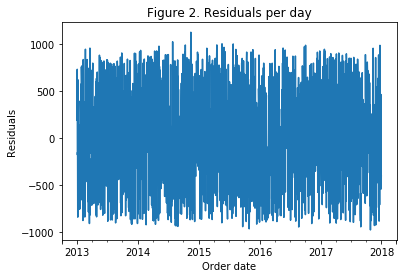

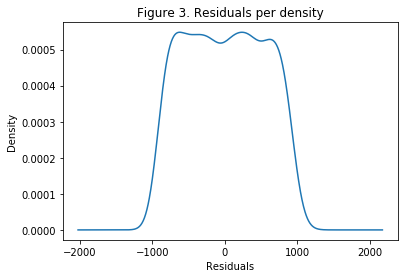

                 0
count  1826.000000
mean      0.001023
std     539.725104
min    -976.557144
25%    -465.129647
50%       6.153896
75%     463.499397
max    1125.068985


In [12]:
residuals = pd.DataFrame(results.resid)
residuals.plot()
plt.ylabel('Residuals')
plt.legend().remove()
plt.title("Figure 2. Residuals per day")
plt.show()
residuals.plot(kind='kde', label="Residuals")
plt.xlabel('Residuals')
plt.legend().remove()
plt.title("Figure 3. Residuals per density")
plt.show()
print(residuals.describe())

## Conclusion
Figure 1 shows that there are no patterns in the sales. This makes it very hard to create an accurate model.
The results show that the predictions are around the mean.
In figures 2 and 3 it is shown that the error rate is mostly within 1000 sales. This is not very good.

If there were some patterns in the sales numbers the predictions would be more accurate.